In [140]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice

In [150]:
# Read files
first_user_df = pd.read_csv("first_user_data.csv")
second_user_df = pd.read_csv("second_user_data.csv")
first_user_info_df = pd.read_csv("first_user_info.csv")
second_user_info_df = pd.read_csv("second_user_info.csv")

In [142]:
print(len(first_user_df))
print(len(second_user_df))

1282
109


In [143]:
# Drop duplicate records
first_user_df.drop_duplicates(keep = False, inplace = True)
second_user_df.drop_duplicates(keep = False, inplace = True)

In [144]:
print(len(first_user_df))
print(len(second_user_df))

1026
105


In [145]:
first_user_df.head()

,id,song,artist,album,popularity,duration,img_url,genres
32,2MwjcKcekaSQyecQVkmGEw,那些年,Hu Xia,"那些年,我們一起追的女孩 電影原聲帶",49,371080,https://i.scdn.co/image/ab67616d0000b273d73ea8...,"['mainland chinese pop', 'mandopop']"
33,70CudhEdB3miT1xxs5PuuZ,BECAUSE OF YOU - Piano,By2,"《親愛的,公主病》 OST part.1",42,263294,https://i.scdn.co/image/ab67616d0000b273904469...,"['mandopop', 'singaporean mandopop', 'singapor..."
35,0G24cauyLcnvW7YJvJQg21,PONPONPON,梨亞,"《親愛的,公主病》原聲大碟",18,195840,https://i.scdn.co/image/ab67616d0000b273e56127...,[]
37,2ZSB7IqV9ApkaKFApdRq93,A Little Love,Fiona Fung,A Little Love,43,189386,https://i.scdn.co/image/ab67616d0000b2735c61e2...,[]
38,67UmmvDAlOdU36yP3TmSdE,微微一笑很傾城,楊洋,微微一笑很傾城,47,204828,https://i.scdn.co/image/ab67616d0000b273ae1fff...,['mainland chinese pop']


In [146]:
second_user_df.head()

,id,song,artist,album,popularity,duration,img_url,genres
0,4fpEuKIzTLmMJnYwFU0oqr,Death with Dignity,Sufjan Stevens,Carrie & Lowell,50,239508,https://i.scdn.co/image/ab67616d0000b2734dfbe3...,"['baroque pop', 'chamber pop', 'freak folk', '..."
1,4tcwdkKzXn0Tsyz3WtH3gc,In My Mind (feat. Brian Viglione),Amanda Palmer,Goes Down Under,0,253506,https://i.scdn.co/image/ab67616d0000b2738c7753...,"['anti-folk', 'dark cabaret', 'piano rock', 's..."
2,7yC7FWZz24L43brXzNpLWT,To All of You,Syd Matters,Someday We Will Foresee Obstacles,55,283266,https://i.scdn.co/image/ab67616d0000b273baf75f...,"['folktronica', 'french indie folk']"
3,3jfZ9M23l0L7RxzYMTgBTv,Looking Out for You,Joy Again,Looking Out for You,79,179499,https://i.scdn.co/image/ab67616d0000b2735448a3...,"['indie garage rock', 'indie pop']"
4,24HPkbkXJsIFC4eyg63zgQ,Wraith Pinned to the Mist and Other Games,of Montreal,The Sunlandic Twins,57,255613,https://i.scdn.co/image/ab67616d0000b27338a6cc...,"['alternative dance', 'alternative rock', 'ant..."


In [147]:
first_user_df["artist"].value_counts()

first_user_df["popularity"].value_counts()


0     143
49     30
74     24
41     24
43     20
     ... 
84      2
87      1
15      1
11      1
93      1
Name: popularity, Length: 87, dtype: int64

In [148]:
first_user_df.sort_values(by=["popularity"])

,id,song,artist,album,popularity,duration,img_url,genres
283,4a1FFgdBIbAvyn4d40YAPZ,LOSER,BIGBANG,MADE,0,219428,https://i.scdn.co/image/ab67616d0000b2735c2254...,"['k-pop', 'k-pop boy group']"
290,6aU0ZgV3IYn2vW8KBtI0eN,Like a Cat,AOA,Like a Cat,0,219533,https://i.scdn.co/image/ab67616d0000b273f3a74c...,"['k-pop', 'k-pop girl group']"
590,4q5R6rdomdPOwVxJrExLkc,"The Day (From ""Mr. Sunshine [Original Televisi...",Park Hyo Shin,"The Day (From ""Mr. Sunshine [Original Televisi...",0,292526,https://i.scdn.co/image/ab67616d0000b2736ff073...,['korean pop']
298,5JYyEUEHdmm6dFc5Bygkgx,Ribbon,Beast,Highlight,0,234798,https://i.scdn.co/image/ab67616d0000b2736a71cf...,"['k-pop', 'k-pop boy group']"
299,7aD3tjbqZijZhYvJ6R6RU4,On Rainy Days,Beast,So Beast,0,225800,https://i.scdn.co/image/ab67616d0000b27380ad49...,"['k-pop', 'k-pop boy group']"
...,...,...,...,...,...,...,...,...
278,3U4isOIWM3VvDubwSI3y7a,All of Me,John Legend,Love In The Future (Expanded Edition),84,269560,https://i.scdn.co/image/ab67616d0000b27394c921...,"['neo soul', 'pop', 'pop soul', 'r&b', 'urban ..."
963,0ct6r3EGTcMLPtrXHDvVjc,The Nights,Avicii,The Days / Nights,85,176658,https://i.scdn.co/image/ab67616d0000b2730ae4f4...,"['dance pop', 'edm', 'pop', 'pop dance']"
395,7qiZfU4dY1lWllzX7mPBI3,Shape of You,Ed Sheeran,÷ (Deluxe),85,233712,https://i.scdn.co/image/ab67616d0000b273ba5db4...,"['pop', 'uk pop']"
1244,2CVChktEKBsM6v4IfdFU5k,double take,dhruv,double take,87,171743,https://i.scdn.co/image/ab67616d0000b2737eab04...,"['chill r&b', 'nyc pop']"


In [160]:
def genreAnalysis(dataframe, user_dataframe):
    user_genres = []
    name = user_dataframe["display_name"]
    
    for genre in dataframe["genres"]:
        genres = genre.replace("[","").replace("]","").replace("'","").split(", ")
        if genres:
            user_genres += genres

    user_genres = [i for i in user_genres if i]

    user_genres_dict = dict()

    for genre in user_genres:
        user_genres_dict[genre] = user_genres_dict.get(genre,0) + 1

    def take(n, iterable):
        return dict(islice(iterable, n))

    sorted_user_genres =  {k: v for k, v in sorted(user_genres_dict.items(), 
                                                         reverse = True, key=lambda item: item[1])}

    top_10_user_genres = take(10, sorted_user_genres.items())

    plt.barh(list(top_10_user_genres.keys()), top_10_user_genres.values() , align='center')
    plt.xlabel("Counts")
    plt.ylabel("Genres")
    plt.show()

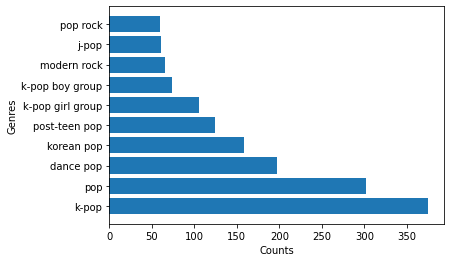

In [161]:
genreAnalysis(first_user_df, first_user_info_df)

{'indie pop': 18, 'japanese alternative rock': 16, 'indie garage rock': 14, 'j-rock': 9, 'j-pop': 9, 'indie rock': 8, 'modern rock': 8, 'neo-psychedelic': 6, 'stomp and holler': 5, 'rock': 5}


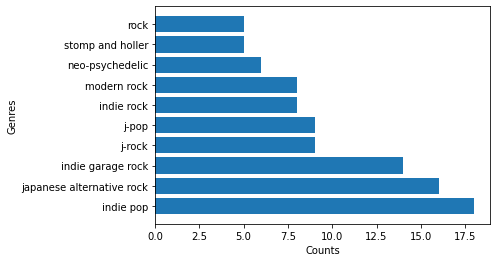

In [159]:
genreAnalysis(second_user_df, second_user_info_df)